In [ ]:
!pip install python-igraph
!pip install pycairo

     |████████████████████████████████| 3.2 MB 18.5 MB/s 
  Created wheel for python-igraph: filename=python_igraph-0.9.8-py3-none-any.whl size=9070 sha256=9e03d3bfd9f3d37415cf4f57941d0737c19a06949b84054599ebd3973da53eea
  Stored in directory: /root/.cache/pip/wheels/15/86/ef/b8bcdfbcb1c489771ad256c7cd1eb4971cdb7f3f670938b798
Successfully built python-igraph
     |████████████████████████████████| 344 kB 34.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  ERROR: Failed building wheel for pycairo
Failed to build pycairo
ERROR: Could not build wheels for pycairo which use PEP 517 and cannot be installed directly


In [ ]:
import requests
import igraph as ig
from bs4 import BeautifulSoup

In [ ]:
def get_page_content(url):
    headers = {'Accept-Encoding': 'identity'}
    r = requests.get(url, headers=headers)
    soup = BeautifulSoup(r.content, 'html.parser')
    # print(soup.prettify())
    return soup

In [ ]:
def get_vertices_hier(soup):
    indice = soup.findAll('li', {'class':'toclevel-1'})

    vtitle = ['root']
    vidx = ['0']
    edges = []

    for line in indice:
    #     print(line.getText())
        line = line.get_text()
        if line == '':
            continue
            
        line_split = line.split('\n')
        
        if len(line_split) > 1:
            for subsec in line_split:
                if subsec == '':
                    continue
                number = subsec.split(' ')[0]
                title = ' '.join(subsec.split(' ')[1:])
                vtitle.append(title)
                vidx.append(number)

                n = len(number) - 1
                while number[n] != '.' and n > 0:
                    n -= 1

                parent = number[:n]
                if parent == '':
                    parent = '0'

                edges.append((number, parent))
        else:
            number = line.split(' ')[0]
            title = ' '.join(line.split(' ')[1:])
            vtitle.append(title)
            vidx.append(number)
            edges.append((number, '0'))
    
    g = ig.Graph()
    g.add_vertices(len(vtitle))
    g.vs['name'] = vidx
    g.vs['title'] = vtitle
    g.add_edges(edges)
    return g

In [ ]:
def get_text_info(soup, g, file):
    output = open(file, 'w')
    header = ''
    for element in soup.find_all():
        if element.name == 'p':
            if 'Coordinates:' in element.get_text():
                continue
            header += element.get_text()    
        if 'class' in element.attrs:
            if element.attrs['class'][0] == 'toc':
                break
    header = str(header).replace('\n', ' ')
    output.write('0\troot\t' + header + '\n')
    v = g.vs.select(title_eq='root')
    v['text'] = header
    
    
    for element in soup.findAll('span', {'class': 'mw-headline'}):
        key = element.get_text()
        text = ''
        for part in element.find_all_next():
            if 'class' in part.attrs:
                if part.attrs['class'][0] == 'mw-headline':
                    break
            if part.name == 'p':
                text += ' ' + part.get_text()
        
        text = str(text).replace('\n', ' ')
        v = g.vs.select(title_eq=key)
        output.write('%s\t%s\t%s\n' % (v['name'][0], key, text))
    
    output.close()
    return g

In [ ]:
soup = get_page_content('https://en.wikipedia.org/wiki/Biology')
g = get_vertices_hier(soup)
g = get_text_info(soup, g, 'text_file.csv')

In [ ]:
url_list = {
    'biology': 'https://en.wikipedia.org/wiki/Biology',
    'united_states': 'https://en.wikipedia.org/wiki/United_States',
    'haiti': 'https://en.wikipedia.org/wiki/Haiti',
    'cuba': 'https://en.wikipedia.org/wiki/Cuba'
}

In [ ]:
texts_graphs = []

for key, url in url_list.items():
    print(key)
    soup = get_page_content(url)
    g = get_vertices_hier(soup)
    g = get_text_info(soup, g, '%s_wiki.csv' % key)
    texts_graphs.append(g)
    # print(g)
    # xnet.igraph2xnet(g, '%s_wiki.xnet' % key)

biology
united_states
haiti
cuba


In [ ]:
import itertools
import numpy as np
import string
from itertools import combinations

l = list(string.ascii_lowercase)
vowels = ['a', 'e', 'i', 'o', 'u']

In [ ]:
def union(a, b):
    return a | b

def intersec(a, b):
    return a & b

def compl1(a, b=None):
    return set(l) - a

def compl2(a, b):
    return set(l) - b

def op1(a, b):
    return a

def op2(a, b):
    return b

def op3(a, b):
    return compl1(intersec(a, b))

def op4(a, b):
    return intersec(compl1(a), b)

def op5(a, b):
    return intersec(a, compl1(b))

def op6(a, b):
    return compl1(union(a, b))

def op7(a, b):
    return union(compl1(a), b)

def op8(a, b):
    return union(a, compl1(b))

def op9(a, b):
    return union(op4(a, b), op5(a, b))

def op10(a, b):
    return union(intersec(a, b), intersec(compl1(a), compl1(b)))

def similarity(a, b):
    return len(a & b)/len(a | b)

In [ ]:
def search_similarity(sets):
    operations = [union, intersec, compl1, compl2, op1, op2, op3, op4, 
                op5, op6, op7, op8, op9, op10]

    total = len(sets)
    for a in range(total):
        s_max = -1
        A = sets[a]
        valid = [sets[i] for i in range(total) if i != a]
        
        comb = combinations(valid, 2)
        for pair in comb:
            B = pair[0]
            C = pair[1]
            for op in operations:
                result = op(B, C)
                s = similarity(A, result)
                print(s, s_max)
                if s > s_max:
                    infos = (B, C, op.__name__)
                    s_max = s
        print('set', a)
        print('infos', infos)
        print('sim', s_max)
        print()
            

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import string 
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer


def preprocess(t):
    if t == None:
        return []
    t = t.lower()
    t = "".join([char for char in t if char not in string.punctuation])
    words = nltk.word_tokenize(t)
    stop_words = stopwords.words('english')
    words = [word for word in words if word not in stop_words]

    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in words]

    return stemmed


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import pandas as pd

text_bio = pd.read_csv('biology_wiki.csv', sep='\t')
text_bio = text_bio.dropna()
print(text_bio.head())

text_processed = []
for idx, row in text_bio.iterrows():
    t = preprocess(row[2])
    if len(t) == 0:
        continue
    text_processed.append(set(t))

       0  ...  Biology is the  scientific study of life.[1][2][3] It is a natural science with a broad scope but has several unifying themes that tie it together as a single, coherent field.[1][2][3] For instance, all organisms are made up of  cells that process hereditary information encoded in genes, which can be transmitted to future generations. Another major theme is evolution, which explains the unity and diversity of life.[1][2][3] Energy processing is also important to life as it allows organisms to move, grow, and reproduce.[1][2][3] Finally, all organisms are able to regulate their own internal environments.[1][2][3][4][5] Biologists are able to study life at multiple levels of organization.[1] From the molecular biology of a cell to the anatomy and physiology of plants and animals, and evolution of populations.[1][6] Hence, there are multiple subdisciplines within biology, each defined by the nature of their research questions and the tools that they use.[7][8][9] Like other

In [ ]:
search_similarity(text_processed)

# Códigos - Alexandre

In [ ]:
!pip install python-igraph
!pip install xnetwork

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random

from igraph import *
import xnetwork as xnet

import networkx as nx

     |████████████████████████████████| 3.2 MB 7.2 MB/s 
  Created wheel for python-igraph: filename=python_igraph-0.9.8-py3-none-any.whl size=9070 sha256=d30f602b05ac38cd8551e63e328bcac88ed799d6097209625b82102b891461ab
  Stored in directory: /root/.cache/pip/wheels/15/86/ef/b8bcdfbcb1c489771ad256c7cd1eb4971cdb7f3f670938b798
Successfully built python-igraph


In [ ]:
#Para tratamento dos textos - tokenização
import pickle
import requests
import igraph as ig
from bs4 import BeautifulSoup


import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')

import string 
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn

def joinSpace(strings):
	stringOut = ''
	for i in strings:
		stringOut = stringOut + ' ' + i
	return stringOut

def removePonctuation(text):
	"""
	      Remove ponctuation from a given text.
	      
	      Parameters
	      ----------
	      text : string
		  Input string
	      
	      Output
	      ----------
	      text : string
		  text without ponctuation
	"""
	return "".join([ch if ch not in string.punctuation else ' ' for ch in text])

	

def removePonctuationAndSymbols(raw):
	"""
	      Remove ponctuation and symbols from a given text.
	      
	      Parameters
	      ----------
	      text : string
		  Input string
	      
	      Output
	      ----------
	      text : string
		  text without ponctuation
	"""
	tokens = nltk.wordpunct_tokenize(raw)
	text = nltk.Text(tokens)
	words = [w.lower() for w in text if w.isalpha()]
	return joinSpace(words)
	
def get_wordnet_pos(pos_tag):
	pos_tag = pos_tag.upper()
	if pos_tag.startswith('J'):
		return wn.ADJ
	elif pos_tag.startswith('V'):
		return wn.VERB
	elif pos_tag.startswith('N'):
		return wn.NOUN
	elif pos_tag.startswith('R'):
		return wn.ADV
	else:
		return wn.NOUN

	
def preprocess(text,removeStopwords=True, lemmatize=True):
	"""
	    Preprocess a given text.
	    
	    Parameters
	    ----------
	    text : string
		Input string
	    removeStopwords : boolean
		If True remove stopwords
	    lemmatize : boolean
		If true lemmatize text
	    
	    Output
	    ----------
	    text : string
		preprocessed text 
	"""
	text = removePonctuationAndSymbols(text)
	wnl = nltk.WordNetLemmatizer()
	tagsOut = []
	tokens = nltk.word_tokenize(text)
	tags = nltk.pos_tag(tokens)
	tags = [tag[1] for tag in tags]
	
	if removeStopwords:
		stopWords = stopwords.words('english')
		tags = [tags[i] for i,token in enumerate(tokens) if token.lower() not in stopWords]
		tokens = [w.lower() for w in tokens if w.lower() not in stopWords]
	
	if lemmatize:
		tags = [get_wordnet_pos(t) for t in tags]
		textLemmatized = [wnl.lemmatize(tokens[i], tags[i]) for i in range(len(tokens))]
		textOut = joinSpace(textLemmatized)
	else:
		textOut = joinSpace(tokens)
	return textOut



def tokenize(text,removePonctuation=True):
	"""
	    Tokenize a given text.
	    
	    Parameters
	    ----------
	    text : string
		Input string
	    removePonctuation : boolean
		If True remove ponctuation from a given text.
	    
	    Output
	    ----------
	    text : list of strings
		list of tokens 
	"""
	tokens = nltk.word_tokenize(text)
	if removePonctuation:
		tokens = [i for i in tokens if i not in string.punctuation]
	return tokens

In [ ]:
#Medidas de Similaridade de Multiconjunto---------------------------------------
def Interiority(x,y):
    n = len(x)
    A = [np.min([x[i],y[i]]) for i in range(n)]
  
    return np.sum(A)/np.min([np.sum(x),np.sum(y)])

def S1(x,y):    #Jaccard Index
    n = len(x)
    A = [np.min([x[i],y[i]]) for i in range(n)]
    B = [np.max([x[i],y[i]]) for i in range(n)]

    return np.sum(A)/np.sum(B)

def S2(x,y):    #Jaccard aditive
    n = len(x)
    A = [np.min([np.abs(x[i]),np.abs(y[i])]) for i in range(n)]
    B = [np.abs(x[i]) + np.abs(y[i]) for i in range(n)]

    return 2*np.sum(A)/np.sum(B)

def S3(x,y):
    n = len(x)
    A = [x[i]*y[i] for i in range(n)]
    B = [np.max([np.abs(x[i]),np.abs(y[i])])**2 for i in range(n)]

    return np.sum(A)/np.sum(B)

def S4(x,y):    #Coincidence
      #return np.sqrt(S1(x,y)*Interiority(x,y))
      return S1(x,y)*Interiority(x,y)

def S5(x,y):    #Coincidence Aditive
      return S2(x,y)*Interiority(x,y)

def S6(x,y):    #Cosine Similarity
      A = [x[i]*y[i] for i in range(len(x))]
      v1 = np.linalg.norm(x)
      v2 = np.linalg.norm(y)

      return np.sum(A)/(v1*v2)

def Similarity(x,y, mode = 'Jaccard'):
    if(mode == 'Interiority'): return Interiority(x,y) #Interiority
    if(mode == 'Jaccard'): return S1(x,y) #Jaccard Index
    if(mode == 'Jaccard_Aditive'): return S2(x,y) #Jaccard Aditive
    if(mode == ''): return S3(x,y)
    if(mode == 'Coincidence'): return S4(x,y) #Coincidence
    if(mode == 'Coincidence_Aditive'): return S5(x,y) #Coincidence Aditive
    if(mode == 'Cosine'): return S6(x,y) #Cosine Similarity
    else: return print('Invalid similarity -mode-')
#-------------------------------------------------------------------------------

# Pegar informações da Wiki-----------------------------------------------------
def get_page_content(url):
    headers = {'Accept-Encoding': 'identity'}
    r = requests.get(url, headers=headers)
    soup = BeautifulSoup(r.content, 'html.parser')
    return soup

def get_vertices_hier(soup):
    indice = soup.findAll('li', {'class':'toclevel-1'})

    vtitle = ['root']
    vidx = ['0']
    for line in indice:
        line = line.get_text()
        if line == '':
            continue
            
        line_split = line.split('\n')
        
        if len(line_split) > 1:
            for subsec in line_split:
                if subsec == '':
                    continue
                number = subsec.split(' ')[0]
                title = ' '.join(subsec.split(' ')[1:])
                vtitle.append(title)
                vidx.append(number)

                n = len(number) - 1
                while number[n] != '.' and n > 0:
                    n -= 1

                parent = number[:n]
                if parent == '':
                    parent = '0'
        else:
            number = line.split(' ')[0]
            title = ' '.join(line.split(' ')[1:])
            vtitle.append(title)
            vidx.append(number)

    return vidx, vtitle

def get_text(soup):
    text = []
    header = ''
    for element in soup.find_all():
        if element.name == 'p':
            if 'Coordinates:' in element.get_text():
                continue
            header += element.get_text()    
        if 'class' in element.attrs:
            if element.attrs['class'][0] == 'toc':
                break
    text.append(str(header).replace('\n', ' '))

    for element in soup.findAll('span', {'class': 'mw-headline'}):
            key = element.get_text()
            tx = ''
            for part in element.find_all_next():
                if 'class' in part.attrs:
                    if part.attrs['class'][0] == 'mw-headline':
                        break
                if part.name == 'p':
                    tx += ' ' + part.get_text()
            
            text.append(str(tx).replace('\n', ' '))
    return text
#-------------------------------------------------------------------------------

#determna o nivel da hierarquia de cada nó
def name2lavels(name, char = '.'):
    levels = []
    ch = char
    for a in name:
        if (a == '0'): levels.append(0)
        else:
            n = 1
            for i in a:
                if (i == ch): n+=1
            levels.append(n)

    return levels

#revome os filhos de pais com texto vazio
def remove_empty_text(name, title, text):
    remove = []
    aux = ''
    for i in range(len(name)):
        n = len(text[i])
        if (n<20):
            remove.append(i)
            aux = name[i]
            aux_size = len(aux)
            for j in range(i+1,len(name)):
                if(aux == name[j][:aux_size]): remove.append(j)

    select = [i for i in range(len(name)) if (i not in remove)]

    data_name = name
    data_title = title
    data_text = text

    name = []
    title = []
    text = []

    for i in select:
        name.append(data_name[i])
        title.append(data_title[i])
        text.append(data_text[i])

    return name, title, text

# gerar os vetores de caracteristicas
def text2W(text):
    tokens = []
    for tx in text:
        tokens.append(tokenize(preprocess(tx,removeStopwords=True, lemmatize=True)))

    all_words = []
    for t in tokens:
        for i in t:
            if (i not in all_words): all_words.append(i)

    W = [[0 for _ in range(len(all_words))] for _ in range(len(tokens))]  
    for i, t in enumerate(tokens):
        for j in t: W[i][all_words.index(j)]+=1

    return W

#torna zero os -lim-% dos menores valores de um vetor (faz o percentil)
def vecLim(vec, lim=0.1):
    if(lim>1): lim=1
    if(lim<0): lim=0
    vec = np.array(vec)
    n = round((lim)*len(vec))

    aux = vec.tolist().copy()
    for i in range(n): aux.remove(np.min(aux))
    m = np.min(aux)

    vet =[]
    for i in vec:
        if (i>=m): vet.append(i)
        else: vet.append(0)

    return vet

#Matriz de adjacencia da arvore de hierarquia
def Index2Adj(h_index):

    vector=[i for i in range(len(h_index))]
    n = len(vector)

    #lista das ligações considerando as hierarquias
    list_g = []
    for i in range(n):
        for j in range(i+1,n):
            if (h_index[j]==h_index[i]+1):list_g.append((i,j))
            if (h_index[j]==h_index[i]): break

    #Grafo com as hierarquias
    G = nx.Graph()
    G.add_nodes_from(vector)
    G.add_edges_from(list_g)

    return nx.adjacency_matrix(G).todense()

#define a posição dos nós com base na hierarquia
def Position_Tree(h_index):
    vector=[i for i in range(len(h_index))]
    n = len(vector)

    #lista das ligações considerando as hierarquias
    list_g = []
    for i in range(n):
        for j in range(i+1,n):
            if (h_index[j]==h_index[i]+1):list_g.append((i,j))
            if (h_index[j]==h_index[i]): break

    #Grafo com as hierarquias
    G = nx.Graph()
    G.add_nodes_from(vector)
    G.add_edges_from(list_g)

    return nx.layout.spring_layout(G)

# gerar uma rede de conecçãoe entre os textos (faz a visualização)
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']
def Matrix2Network(M, h_index, limit=None, pos=None, width_tree = 1, save_name=None):
    #colocando as hierarquias em uma arvore
    vector=[i for i in range(len(M))]
    n = len(vector)

    #lista das ligações considerando as hierarquias
    list_g = []
    for i in range(n):
        for j in range(i+1,n):
            if (h_index[j]==h_index[i]+1):list_g.append((i,j))
            if (h_index[j]==h_index[i]): break

    #Grafo com as hierarquias
    G = nx.Graph()
    G.add_nodes_from(vector)
    G.add_edges_from(list_g)

    if (pos == None): position = nx.layout.spring_layout(G)
    else: position = pos
    node_colors = [colors[h_index[i]] for i in range(n)]
    node_sizes = np.array([np.sum(W[i]) for i in range(len(W))])
    node_sizes = node_sizes**1.5/10

    #Similaridade entre os textos
    edges_lsit = [[(i,j) for j in range(n)]for i in range(n)]
    edges_lsit = np.array(edges_lsit)
    edges_lsit = edges_lsit.reshape((n*n,2)).tolist()
    edges_lsit = [(edges_lsit[i][0],edges_lsit[i][1]) for i in range(len(edges_lsit))]

    G2 = nx.DiGraph()
    G2.add_nodes_from(vector)
    G2.add_edges_from(edges_lsit)

    edge_alphas = M
    for i in range(len(M)): edge_alphas[i][i] = 0
    edge_alphas = np.array(edge_alphas)
    edge_alphas = edge_alphas.reshape((len(M)*len(M)))
    
    edge_alphas = edge_alphas/np.max(edge_alphas) #normalização
    if (limit!=None): edge_alphas = np.array(vecLim(edge_alphas, lim=limit)) #determinar um limite pra os edges que aparecem
    edge_alphas = 15*(edge_alphas**4) #evidenciar as diferenças entre os valores


    #Draw graph
    plt.figure(figsize=(10,9))

    edges = nx.draw_networkx_edges(G2, position, node_size=node_sizes, arrowstyle='-', width=edge_alphas, edge_color='darkred')
    for i in range(G2.number_of_edges()): edges[i].set_alpha(0.2)
    nx.draw(G,position, with_labels=True, font_weight='bold', font_size=16,node_size=node_sizes, node_color=node_colors, width=width_tree)

    plt.tight_layout()
    if(save_name!=None): plt.savefig(save_name)
    plt.show()

## Aplicação dos códigos

https://en.wikipedia.org/wiki/Brazil


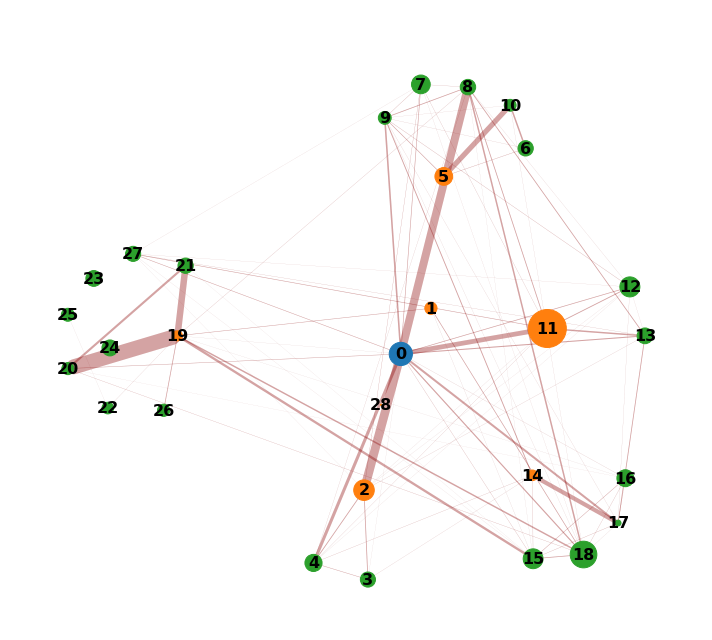

In [ ]:
#parametros
link = 'https://en.wikipedia.org/wiki/Brazil'   #link da pagina
limit = .8             #percentil da ligações removidas
mode = 'Coincidence'   #método de comparação entre os textos

#pegar informações da pagina
wiki_page = get_page_content(link)

name, title = get_vertices_hier(wiki_page)
text = get_text(wiki_page)
name, title, text = remove_empty_text(name, title, text)

h_index = name2lavels(name) #hierarquia dos nós
W = text2W(text) #textos em vetores de multiconjunto


#gerar a matriz de similaridade entra os pares de texto 
M = [] #Coincidence
for i in range(len(W)):
    S = []
    for j in range(len(W)):
        if(i==j): S.append(0)
        else:S.append(Similarity(W[i], W[j], mode=mode))
    M.append(S) 


#print da visualização
pos = Position_Tree(h_index)
Matrix2Network(M, h_index, pos=pos ,limit=limit, width_tree = 0)
